# Visualize model generalizability on Plate 3

In this notebook, we will be looking at the predicted probabilities of each cell that are labeled for either healthy or failing cell type in Plate 3. 

We generate a facet ridge plot to look at the distribution of probabilities for each binary class. 
Bar charts are also generated to look at the counts.

## Import libraries

In [2]:
suppressPackageStartupMessages(suppressWarnings(library(ggplot2))) # plotting
suppressPackageStartupMessages(suppressWarnings(library(dplyr))) # data manipulation
suppressPackageStartupMessages(suppressWarnings(library(ggridges))) # ridge line plots
suppressPackageStartupMessages(suppressWarnings(library(RColorBrewer))) # color palettes

## Load in probabilities from Plate 3

In [3]:
# load in the probabilities
combined_probabilities_path <- file.path(
    paste0(
        "./prob_data/combined_plate_3_predicted_proba.csv"
    )
)
# read in the data from the parquet file
combined_probabilities_df <- read.csv(
    combined_probabilities_path
)
dim(combined_probabilities_df)
head(combined_probabilities_df,2)

[1] 40638    23

,Failing_probas,Healthy_probas,predicted_label,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,⋯,Metadata_Image_Count_Cells,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,model_type
,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.5373328,0.4626672,Failing,B,2,9,Failing,rejected,DMSO,690.5961,⋯,40,1,localhost230405150001,B02,2,2,7,7,f00,shuffled
2,0.4607679,0.5392321,Healthy,B,2,9,Failing,rejected,DMSO,559.4486,⋯,40,1,localhost230405150001,B02,4,4,9,9,f00,shuffled


## Look at the total counts across cell type

In [4]:
# Group by Metadata_cell_type
counts_df <- combined_probabilities_df %>%
  group_by(Metadata_cell_type) %>%
  summarise(count = n()) %>%
  ungroup()

head(counts_df)

Metadata_cell_type,count
<chr>,<int>
Failing,32264
Healthy,8374


## Look at the total counts across cell types the predicted label

In [5]:
# Group by Metadata_cell_type
counts_df <- combined_probabilities_df %>%
  group_by(Metadata_cell_type, predicted_label) %>%
  summarise(count = n()) %>%
  ungroup()

head(counts_df)

`summarise()` has grouped output by 'Metadata_cell_type'. You can override
using the `.groups` argument.


Metadata_cell_type,predicted_label,count
<chr>,<chr>,<int>
Failing,Failing,13108
Failing,Healthy,19156
Healthy,Failing,829
Healthy,Healthy,7545


## Generate ridge plot facet by treatment

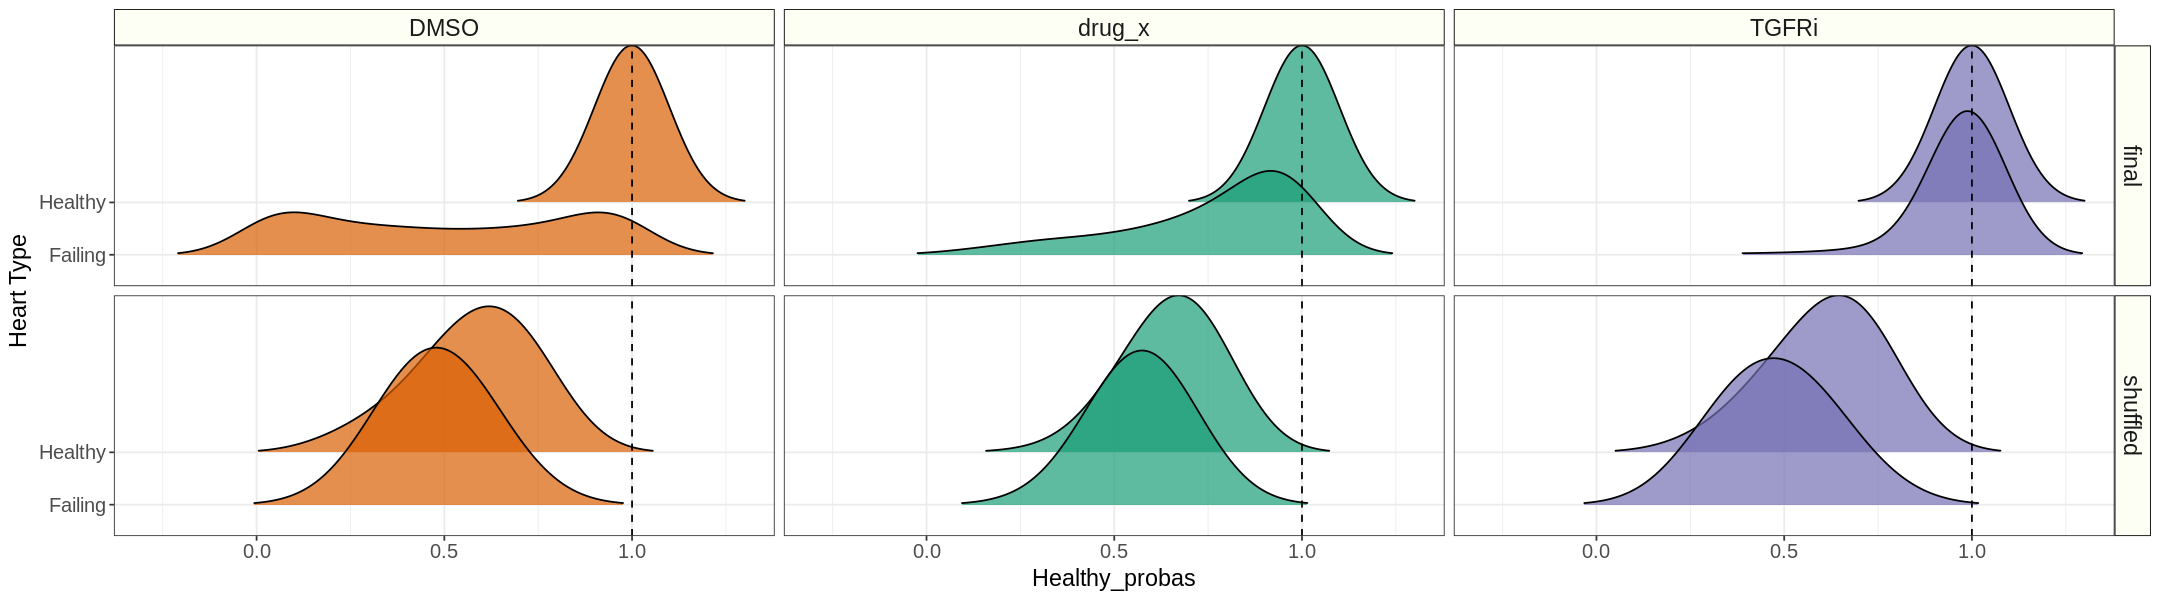

In [17]:
height <- 5
width <- 18
options(repr.plot.width = width, repr.plot.height = height)
# Adjust bandwidth parameter for density estimation to get more relative distributions for treatments with less cells
ridge_plot_healthy <- ggplot(combined_probabilities_df, aes(x = Healthy_probas, y = Metadata_cell_type, fill = Metadata_treatment)) +
  geom_density_ridges(aes(fill = Metadata_treatment), alpha = 0.7, scale = 3, rel_min_height = 0.01, bandwidth = 0.1) +
  scale_fill_manual(values = c(
    "drug_x" = brewer.pal(3, "Dark2")[1],
    "DMSO" = brewer.pal(3, "Dark2")[2],
    "TGFRi" = brewer.pal(3, "Dark2")[3]
  )) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "black") +
  scale_x_continuous(breaks = seq(0, 1, 0.5)) +
  facet_grid(model_type ~ Metadata_treatment, scales = "free_y") +
  labs(y = "Heart Type") +
  theme_bw() +
  theme(legend.position = "none",
      axis.text = element_text(size = 12),
      axis.text.x = element_text(size = 12),
      axis.title = element_text(size = 14),
      strip.text = element_text(size = 14),
      strip.background = element_rect(
          colour = "black",
          fill = "#fdfff4"
      )
    )
  

# Save figure
ggsave("./figures/healthy_prob_ridge_plot_plate_3.png", ridge_plot_healthy, height = 8, width = 12, dpi = 500)

ridge_plot_healthy

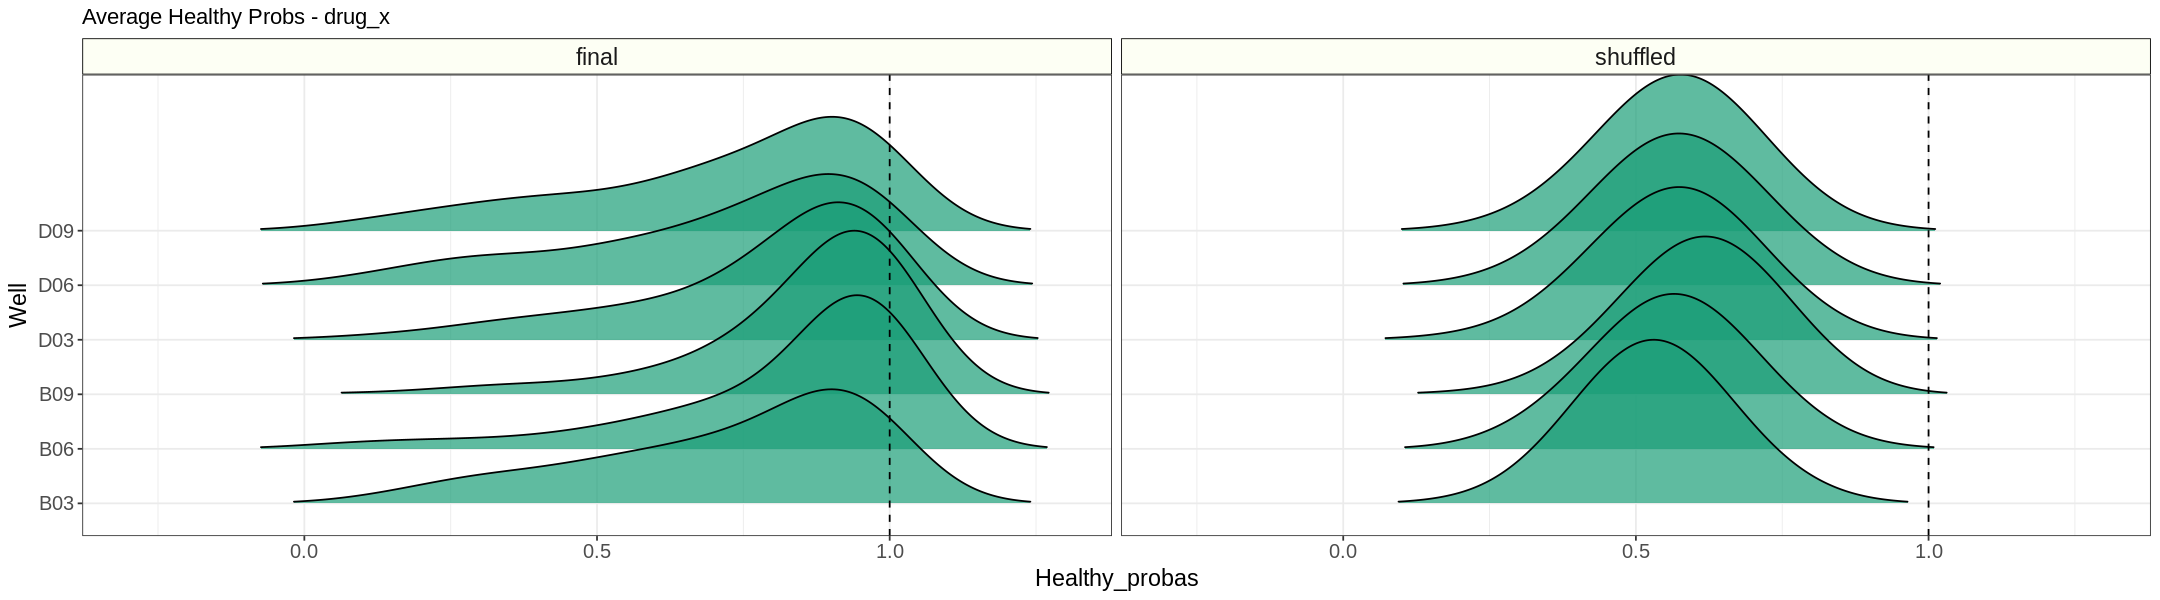

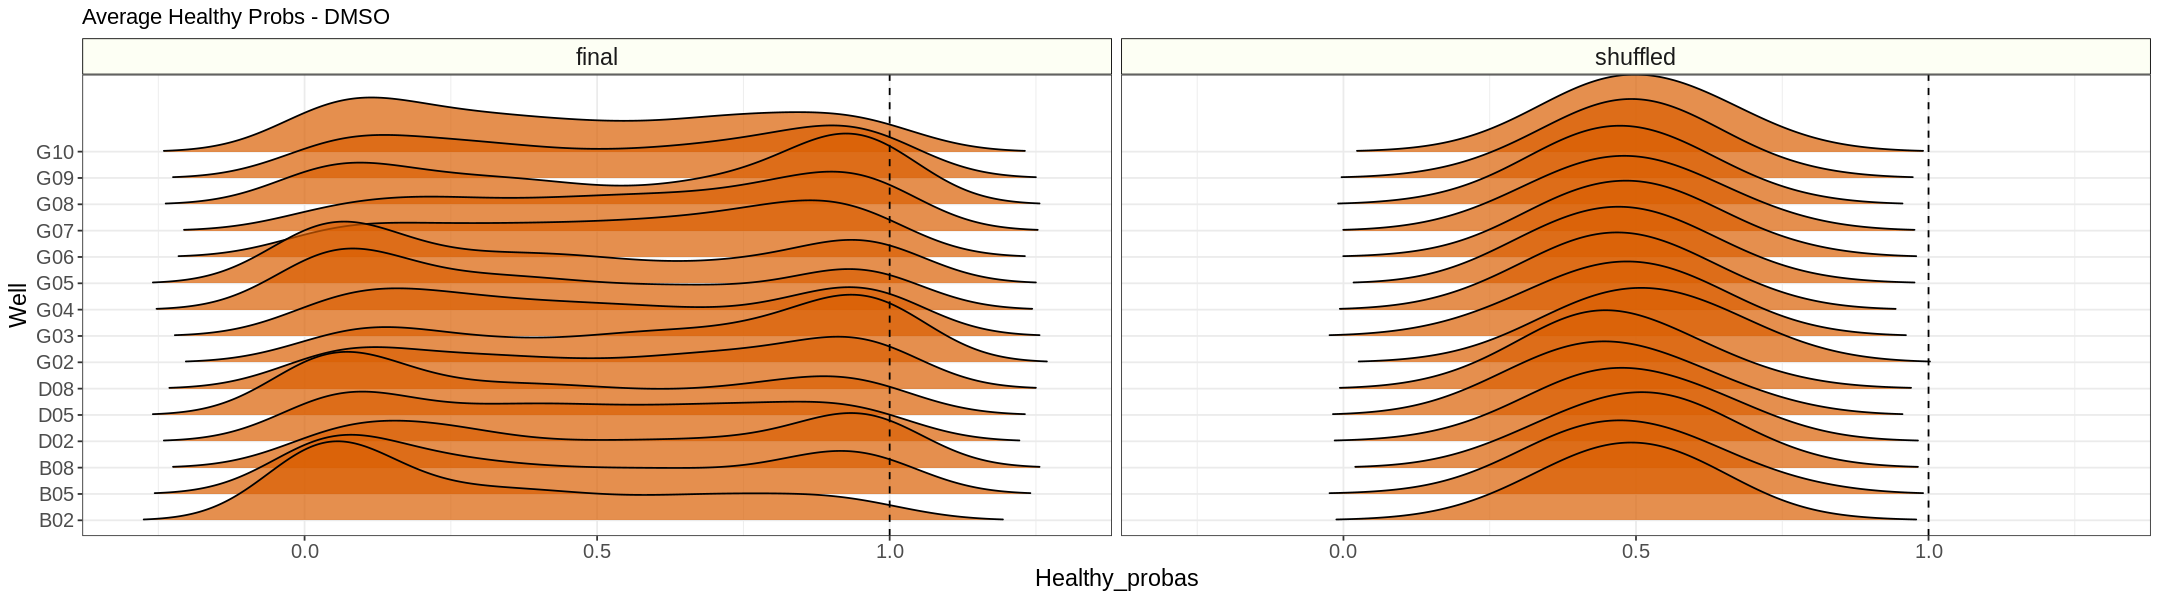

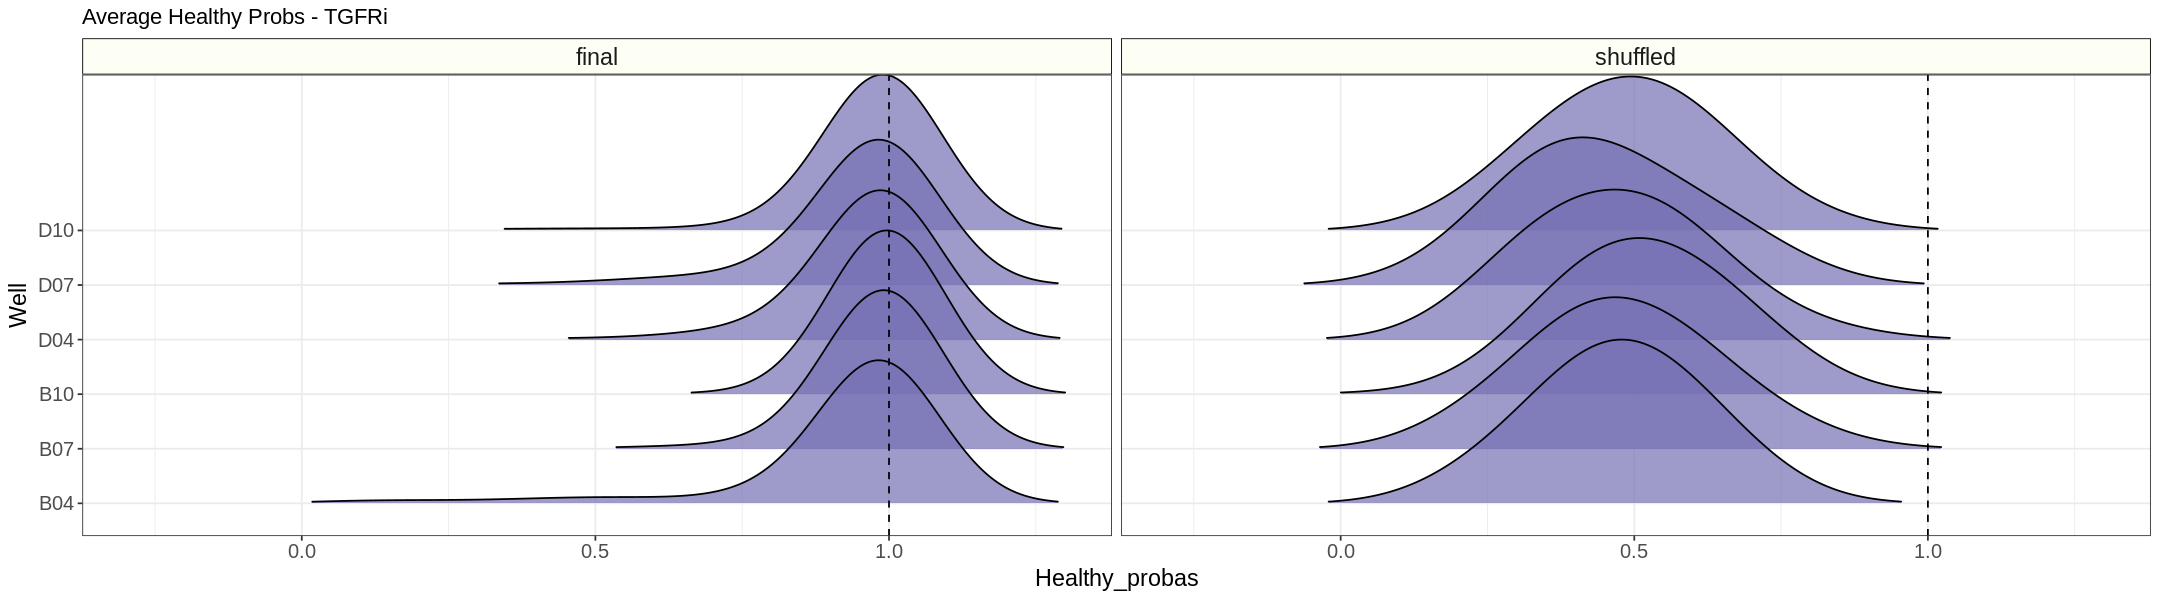

In [44]:
# Function to create a color palette based on treatments
create_color_palette <- function(treatments) {
  colors <- c(
    "drug_x" = brewer.pal(3, "Dark2")[1],
    "DMSO" = brewer.pal(3, "Dark2")[2],
    "TGFRi" = brewer.pal(3, "Dark2")[3]
  )
  return(colors[treatments])
}

# Filter rows for each treatment
drug_x_wells <- combined_probabilities_df[combined_probabilities_df$Metadata_treatment == "drug_x", ]
DMSO_wells <- combined_probabilities_df[combined_probabilities_df$Metadata_treatment == "DMSO", ]
TGFRi_wells <- combined_probabilities_df[combined_probabilities_df$Metadata_treatment == "TGFRi", ]

create_ridge_plot <- function(data, treatment) {
  # Filter rows where Metadata_cell_type is "Failing"
  failing_wells <- data[data$Metadata_cell_type == "Failing", ]

  # Create a color palette based on the treatment
  colors <- create_color_palette(rep(treatment, nrow(failing_wells)))
  
  # Ridge plot for average healthy probabilities across wells within each treatment
  ridge_plot <- ggplot(failing_wells, aes(x = Healthy_probas, y = Metadata_Well)) +
    geom_density_ridges(aes(fill = Metadata_treatment), alpha = 0.7, scale = 3, rel_min_height = 0.01, bandwidth = 0.1) +  # Change here
    scale_fill_manual(values = colors) +
    geom_vline(xintercept = 1, linetype = "dashed", color = "black") +
    scale_x_continuous(breaks = seq(0, 1, 0.5)) +
    facet_grid(~model_type, scales = "free_y") +
    labs(y = "Well") +
    ggtitle(paste("Average Healthy Probs -", treatment)) +
  
    theme_bw() +
    theme(legend.position = "none",
          axis.text = element_text(size = 12),
          axis.text.x = element_text(size = 12),
          axis.title = element_text(size = 14),
          strip.text = element_text(size = 14),
          strip.background = element_rect(
            colour = "black",
            fill = "#fdfff4"
          )
    )
  
  return(ridge_plot)
}


# Create ridge plots for each treatment
ridge_plot_drug_x <- create_ridge_plot(drug_x_wells, "drug_x")
ridge_plot_DMSO <- create_ridge_plot(DMSO_wells, "DMSO")
ridge_plot_TGFRi <- create_ridge_plot(TGFRi_wells, "TGFRi")

# Save figures
ggsave("./figures/drug_x_healthy_prob_ridge_plot.png", ridge_plot_drug_x, height = 8, width = 12, dpi = 500)
ggsave("./figures/DMSO_healthy_prob_ridge_plot.png", ridge_plot_DMSO, height = 8, width = 12, dpi = 500)
ggsave("./figures/TGFRi_healthy_prob_ridge_plot.png", ridge_plot_TGFRi, height = 8, width = 12, dpi = 500)

ridge_plot_drug_x
ridge_plot_DMSO
ridge_plot_TGFRi


In [38]:
# Filter rows where Metadata_cell_type is "Failing"
failing_wells <- DMSO_wells[DMSO_wells$Metadata_cell_type == "Failing", ]

head(failing_wells)

,Failing_probas,Healthy_probas,predicted_label,Metadata_WellRow,Metadata_WellCol,Metadata_heart_number,Metadata_cell_type,Metadata_heart_failure_type,Metadata_treatment,Metadata_Nuclei_Location_Center_X,⋯,Metadata_Image_Count_Cells,Metadata_ImageNumber,Metadata_Plate,Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Metadata_Site,model_type
,<dbl>,<dbl>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,⋯,<int>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,0.5373328,0.4626672,Failing,B,2,9,Failing,rejected,DMSO,690.5961,⋯,40,1,localhost230405150001,B02,2,2,7,7,f00,shuffled
2,0.4607679,0.5392321,Healthy,B,2,9,Failing,rejected,DMSO,559.4486,⋯,40,1,localhost230405150001,B02,4,4,9,9,f00,shuffled
3,0.4095593,0.5904407,Healthy,B,2,9,Failing,rejected,DMSO,330.7563,⋯,40,1,localhost230405150001,B02,6,6,11,11,f00,shuffled
4,0.3859260,0.6140740,Healthy,B,2,9,Failing,rejected,DMSO,114.7747,⋯,40,1,localhost230405150001,B02,7,7,12,12,f00,shuffled
5,0.5513033,0.4486967,Failing,B,2,9,Failing,rejected,DMSO,641.1469,⋯,40,1,localhost230405150001,B02,8,8,13,13,f00,shuffled
6,0.4707993,0.5292007,Healthy,B,2,9,Failing,rejected,DMSO,816.8217,⋯,40,1,localhost230405150001,B02,9,9,14,14,f00,shuffled


In [39]:
# Check unique values in the model_type column
unique(failing_wells$model_type)

[1] "shuffled" "final"

## Look at the counts of predictions across treatments

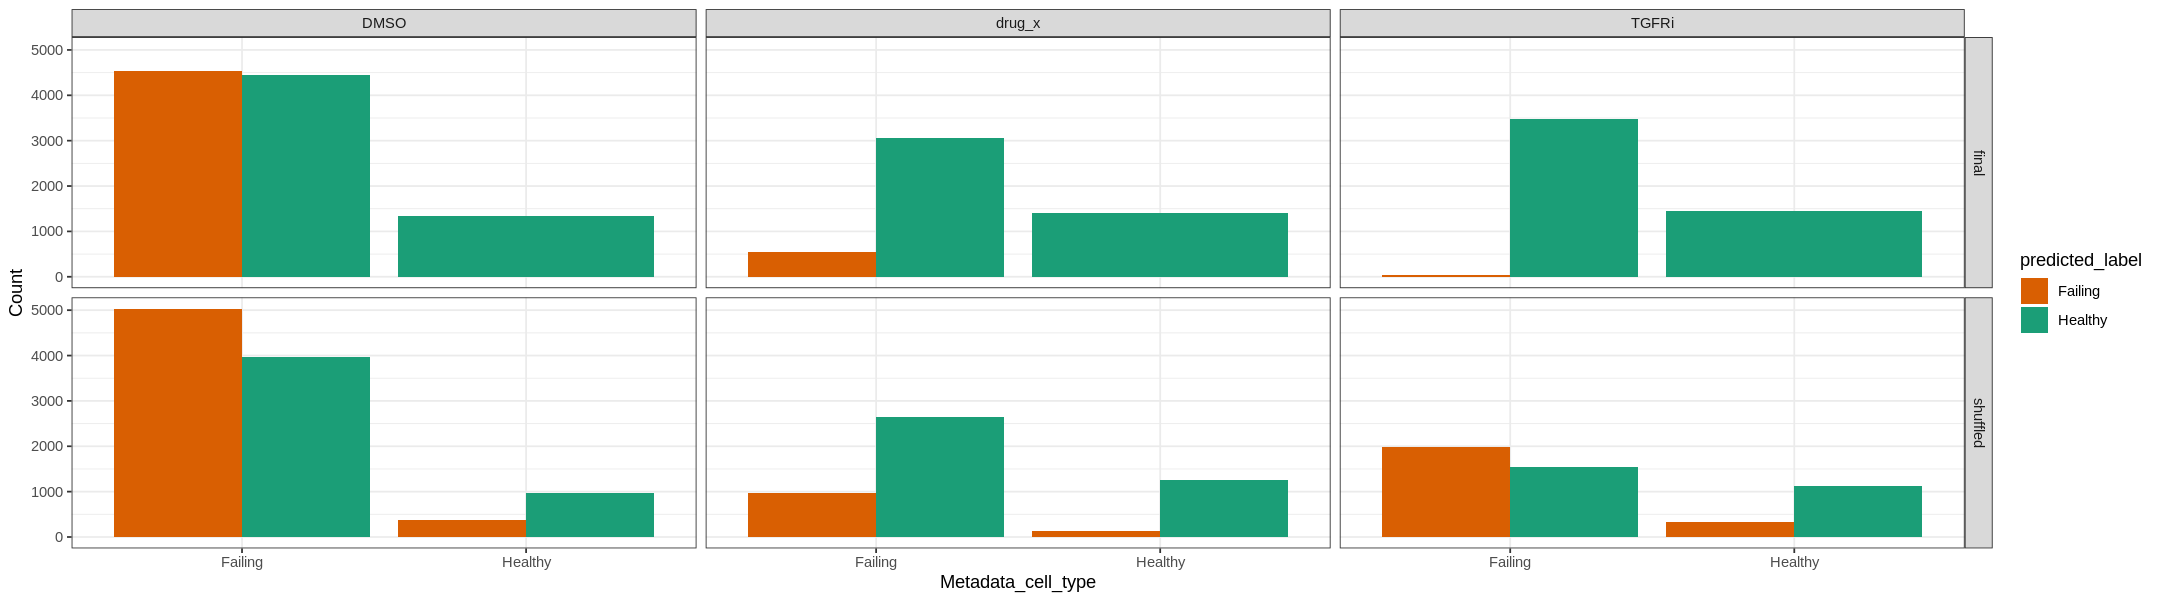

In [6]:
bar_plot_predictions <- (
  ggplot(combined_probabilities_df, aes(x = Metadata_cell_type)) +
  geom_bar(aes(fill = predicted_label), position = "dodge") +
  labs(x = "Metadata_cell_type", y = "Count") +
  facet_grid(model_type~Metadata_treatment) +
  scale_fill_manual(values = c(
        "Healthy" = brewer.pal(3, "Dark2")[1],
        "Failing" = brewer.pal(3, "Dark2")[2]
    )) +
  theme_bw()
)
bar_plot_predictions

## Look at counts across probabilities that are greater than 0.9 (highly confident) across treatments

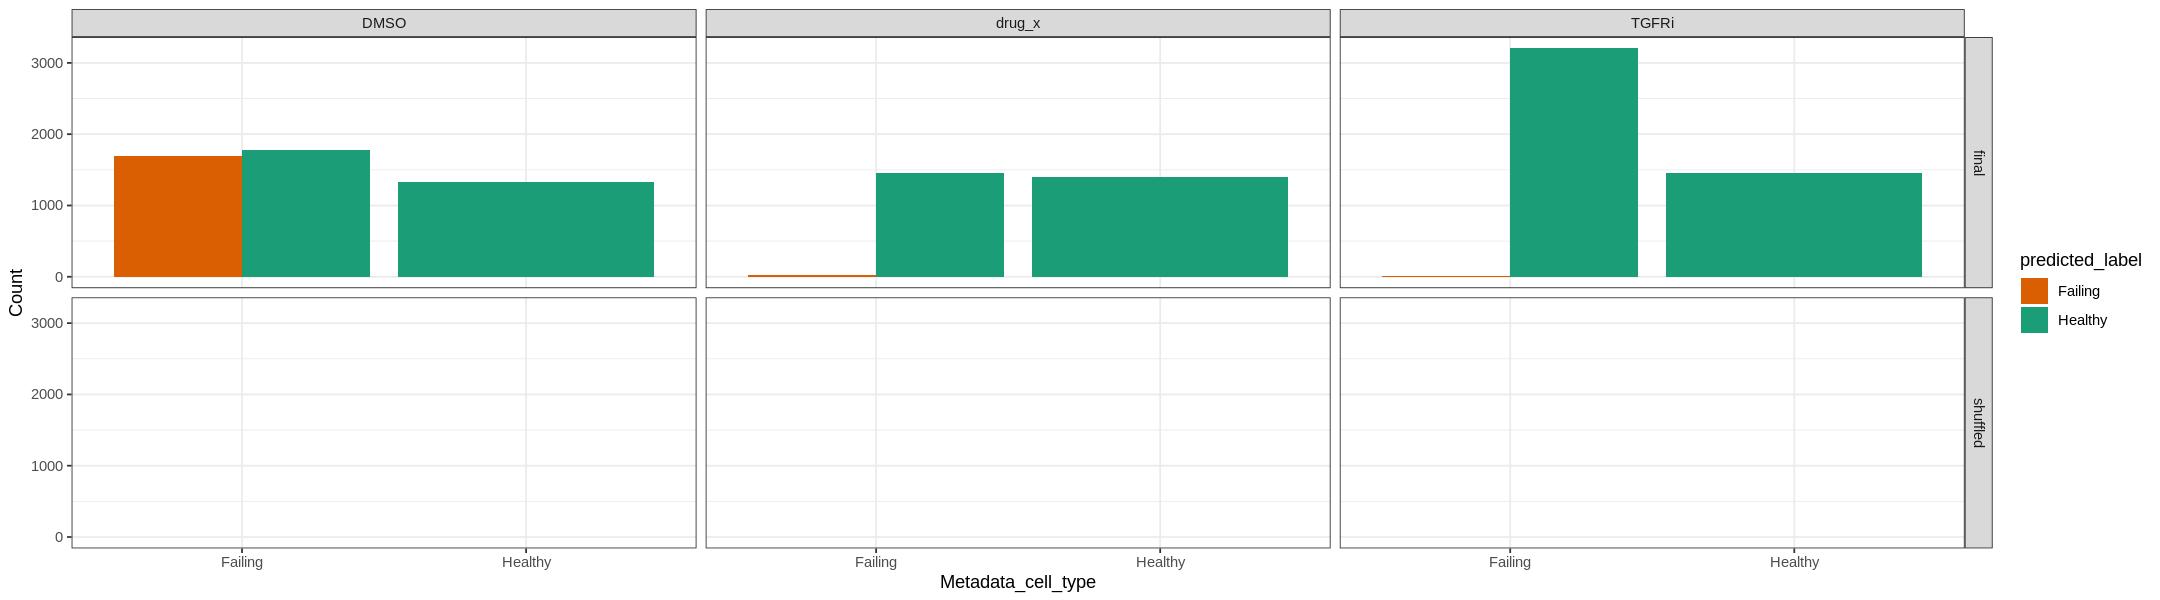

In [7]:
combined_probabilities_df_filtered <- combined_probabilities_df %>%
  filter(Healthy_probas > 0.9 | Failing_probas > 0.9)

bar_plot_predictions_filtered <- (
  ggplot(combined_probabilities_df_filtered, aes(x = Metadata_cell_type)) +
  geom_bar(aes(fill = predicted_label), position = "dodge") +
  labs(x = "Metadata_cell_type", y = "Count") +
  facet_grid(model_type~Metadata_treatment) +
  scale_fill_manual(values = c(
        "Healthy" = brewer.pal(3, "Dark2")[1],
        "Failing" = brewer.pal(3, "Dark2")[2]
    )) +
  theme_bw()
)

bar_plot_predictions_filtered
